In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [ ]:

df = pd.read_csv('combined_file.csv')
df.drop('time', axis=1, inplace=True)
print("Cleaned Data:")
print(df.head())


Cleaned Data:
     current  Real SOC  temprature   voltage
0  14.920631  0.500000  298.150000  3.758524
1  14.958350  0.500154  298.138291  3.797110
2  14.921744  0.500309  298.126651  3.761346
3  15.214570  0.500463  298.115087  4.054990
4  14.921396  0.500617  298.103578  3.762615



Data Summary:
            current      Real SOC    temprature       voltage
count  21601.000000  21601.000000  21601.000000  21601.000000
mean       1.484757      0.606369    300.700988      3.840960
std       20.806990      0.166835      6.189763      0.264449
min      -54.836654      0.299484    295.103792      2.915765
25%      -11.346754      0.468176    296.684351      3.689925
50%       14.921245      0.610792    296.802510      3.872989
75%       15.027576      0.742713    304.060929      4.032147
max       15.370377      0.900275    324.993409      4.528499


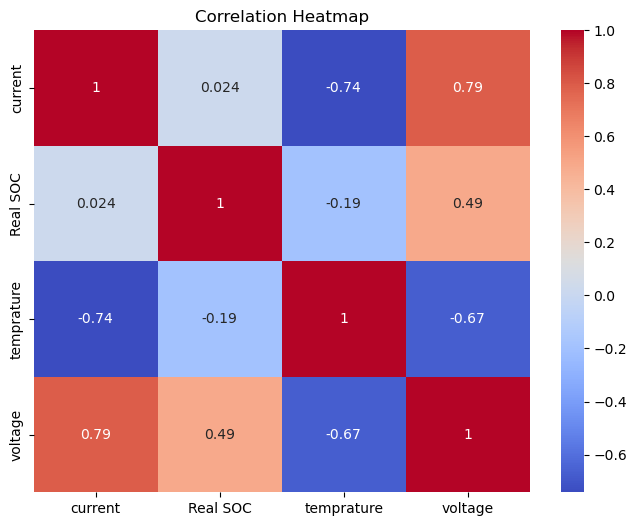

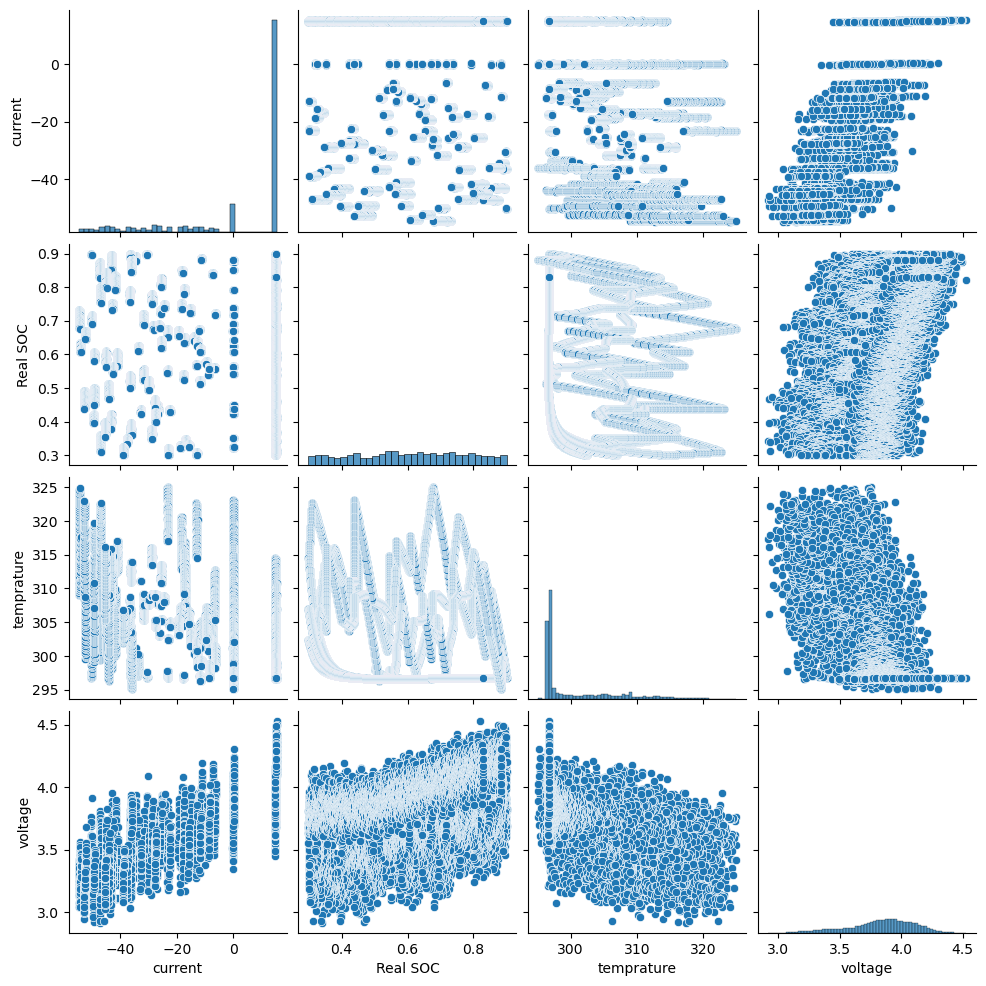

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


print("\nData Summary:")
print(df.describe())


plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


sns.pairplot(df)
plt.show()


In [ ]:
X = df[['current', 'voltage', 'temprature']]
y = df['Real SOC'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

model_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [3, 5, 7,10,14, None],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7,10, None],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2,0.001],
            'max_depth': [3, 5, 7,10]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2,0.001],
            'max_depth': [3, 5, 7,10]
        }
    }
}

results = {}


for name, mp in model_params.items():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results[name] = {
        'Best Params': grid.best_params_,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Model': best_model
    }
    
    print(f"Best Parameters: {grid.best_params_}")
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")



Tuning Linear Regression...
Best Parameters: {}
MSE: 0.0109, RMSE: 0.1043, MAE: 0.0836, R²: 0.6192

Tuning Decision Tree...
Best Parameters: {'max_depth': None, 'min_samples_split': 2}
MSE: 0.0009, RMSE: 0.0307, MAE: 0.0076, R²: 0.9669

Tuning Random Forest...
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
MSE: 0.0006, RMSE: 0.0243, MAE: 0.0079, R²: 0.9794

Tuning Gradient Boosting...
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
MSE: 0.0005, RMSE: 0.0220, MAE: 0.0093, R²: 0.9830

Tuning XGBoost...
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
MSE: 0.0007, RMSE: 0.0262, MAE: 0.0101, R²: 0.9760


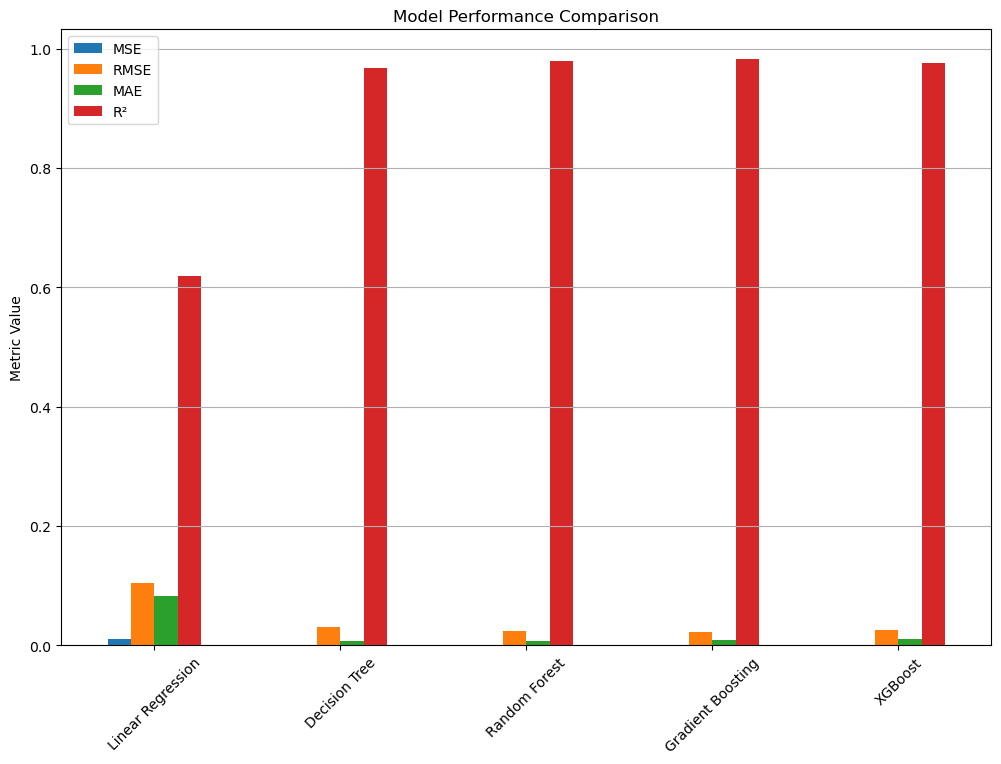

In [ ]:

metrics_df = pd.DataFrame(results).T


metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title("Model Performance Comparison")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


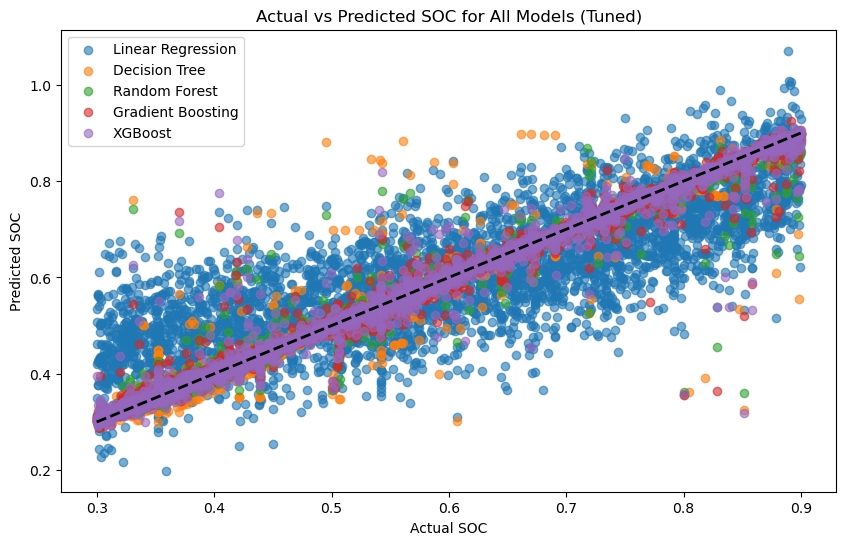

In [10]:
plt.figure(figsize=(10, 6))
for name, res in results.items():
    preds = res['Model'].predict(X_test)
    plt.scatter(y_test, preds, label=name, alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual SOC")
plt.ylabel("Predicted SOC")
plt.title("Actual vs Predicted SOC for All Models (Tuned)")
plt.legend()
plt.show()


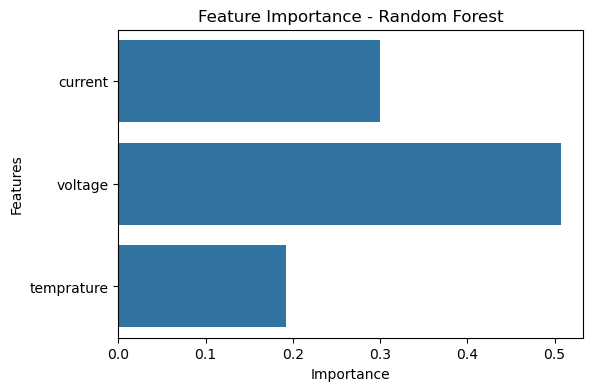

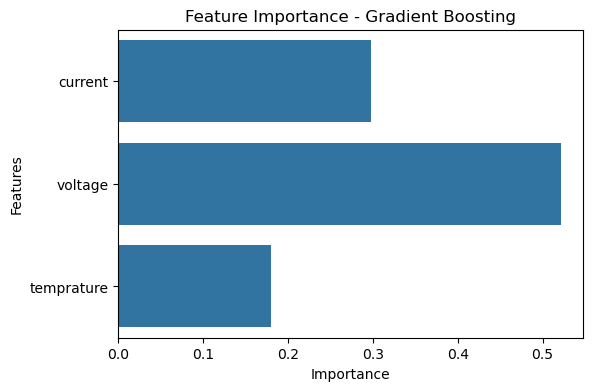

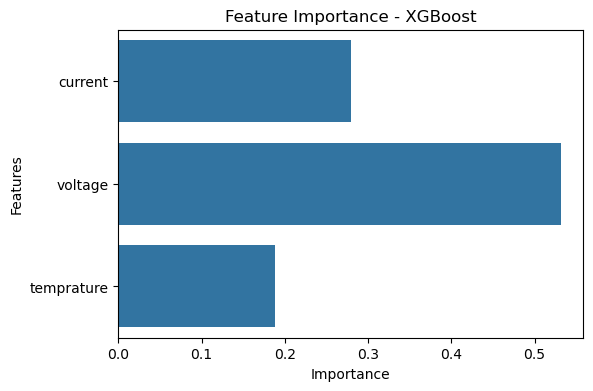

In [11]:
tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost']

for name in tree_models:
    model = results[name]['Model']
    feature_importances = model.feature_importances_
    features = X.columns
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=feature_importances, y=features)
    plt.title(f"Feature Importance - {name}")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()


In [14]:
import joblib  # or you can use pickle

# Folder to save models (optional)
import os
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save each model
for name, res in results.items():
    filename = os.path.join(save_dir, f"{name.replace(' ', '_').lower()}_model.pkl")
    joblib.dump(res['Model'], filename)
    print(f"Saved {name} model to {filename}")


Saved Linear Regression model to saved_models\linear_regression_model.pkl
Saved Decision Tree model to saved_models\decision_tree_model.pkl
Saved Random Forest model to saved_models\random_forest_model.pkl
Saved Gradient Boosting model to saved_models\gradient_boosting_model.pkl
Saved XGBoost model to saved_models\xgboost_model.pkl
